In [1]:
%%bash
nrnivmodl

/usr/bin/xcrun
/Users/anatolii-sorokin/Documents/Projects/neuro-trafic
Mod files: "./h.mod" "./kadist.mod" "./kaprox.mod" "./kdrca1.mod" "./km.mod" "./na3n.mod" "./naxn.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
 => LINKING executable ./special LDFLAGS are:    
Successfully created arm64/special


In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import math
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
#from PyNeuronToolbox import neuromorpho,morphology
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate,load
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm
%matplotlib inline
np.random.seed(123456789)

import re
import pandas as pd

DC = 10 # diffusion coeff [microns^2 s^-1]

cellname = 'dgyrus'
#cellname = 'granule'
#neuromorpho.download('041015-vehicle1', filename=cellname+'_morph.swc')
#cell = morphology.load(cellname+'_morph.swc',use_axon=False)
#cell = load(cellname+'_morph.swc',use_axon=False)


In [3]:
import sushibelt
#import Edita_DG_10reg_10dv_model as model
import Edita_DG_intensity_10reg_10dv_model_dvonly as model
import time
tnorm = np.sum(model.target ** 2)

2024-09-24 16:32:20,259 :: INFO :: function defined
2024-09-24 16:32:20,270 :: INFO :: data read


In [4]:
N=model.N
N

287

In [5]:
tdf=pd.read_csv('data/DG_seg_mapping.csv')
abbDG=tdf['abb']
abbT={}
segIdx={}
for i in range(N):
    abbT[abbDG[i]] = 1+ abbT.get(abbDG[i],0)
    ll=segIdx.get(abbDG[i],[])
    ll.append(i)
    segIdx[abbDG[i]] = ll


In [6]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,allsec_preorder(h)[0](0.5),segment)


In [7]:
tdf=pd.read_csv('data/DG_seg_mapping.csv')
tdf

,Unnamed: 0,N,Name,abb,DtS
0,0,0,dgyrus_morph.soma[0],rd1,0.000000
1,1,1,dgyrus_morph.dend[0],rd1,7.512102
2,2,2,dgyrus_morph.dend[0],rd1,7.512102
3,3,3,dgyrus_morph.dend[0],rd1,7.512102
4,4,4,dgyrus_morph.dend[0],rd1,7.512102
...,...,...,...,...,...
282,282,282,dgyrus_morph.dend[5],rd5,91.692424
283,283,283,dgyrus_morph.dend[5],rd5,91.692424
284,284,284,dgyrus_morph.dend[5],rd5,91.692424
285,285,285,dgyrus_morph.dend[5],rd5,91.692424


In [8]:
expD=pd.read_csv('data/DG_intensity_values_15072024.csv')
#expD=pd.read_csv('data/DG_density_values_15072024.csv')
bgSignal=1e-5
#cname='D0W3'
cname0='D0M3'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

#cname='D7W3'
cname7='D7M3'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #results to fit to
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point


In [9]:
(len(d0w),expD.shape,len(sidx),i,N,model.N)

(287, (10, 13), 12, 286, 287, 287)

In [10]:
#par = [0.8855702481960549,-17.6142146256606,0.12385432691434908,0.9642855946085199,0.5389253732509337,
#       0.272527645830006,0.9129387693392707,0.1297446952024372,0.6107997917511535,1e-07,0.9890938472884612,
#       0.24488136124301582,0.014607108124724532,-10.154176543644859,-11.575055132626284,-6.057936626299734,
#       -6.053467113877346,-6.0477171882104965,-6.028631654679405,-6.036945094549408,-5.999154504640609,
#       -6.00544599147668,-6.0530817424270875]
#cost = 0.0027400475307714973
#chi2=1184.7252031040346
#par = [0.8001576414106837,-8.83311346686456,0.9568695929329514,0.0020138669780257502,0.025377383988998158,0.029948781242701755,
#       0.9999999999999751,0.08896057016913292,0.0004002113170755411,0.014562289941884115,1.0523901851122988e-07,
#       1.0846600291496056e-07,0.9598262098965911,-6.028288531411434]
#cost = 2.283246533053875e-05
#chi2 = 8.532544224511733
#par = [0.0001347573108234385,-7.134175640871103,0.16358340428275822,0.9535886836265206,0.9392082944358957,0.588591654675706,
#       0.9999999999998962,0.761066612409874,0.012928172225454351,0.3308015862956901,1.742438941388552e-07,
#       1.397577721676662e-07,0.9832677483391569,-6.028282727752732]
#cost = 2.283438654048628e-05
#chi2 = 8.534658143069766
#par = [0.0,-17.641758850550943,0.9899980591588442,0.24988968936615671,1.0062994989967052e-07,1e-07,0.06556921170168392,1.0016863619144738e-07,1.0000000000227276e-07,0.00458126556189493,0.0001394007972908521,1e-07,0.999999999999629,-6.063004369056134,-6.070974912176686,-6.057936625641295,-6.053467103903037,-6.04771719102088,-6.0286316572292815,-6.036945095832321,-5.99915450387148,-6.005445989961027,-6.053081737997973]
#cost = 7.174089042842454e-32
#chi2 = 1.9756083405305166e-26
par = [0.0,-17.999999996898115,0.8295867669028679,0.9342243392617688,1e-07,0.7436969370578205,0.18090861212130477,0.03669676565420942,1.9005438889792946e-07,0.9971821327488072,0.5857165290933648,0.0004747792235872804,0.0013503241539911826,-6.063004369333619,-6.070974912176688,-6.057936625629171,-6.053467104093608,-6.047717191020574,-6.0286316572292815,-6.036945095837185,-5.999154503867313,-6.005445989961025,-6.053081740925833]
opt_par = [0.0,-17.999999996898115,0.8295867669028679,0.9342243392617688,1e-07,0.7436969370578205,0.18090861212130477,0.03669676565420942,1.9005438889792946e-07,0.9971821327488072,0.5857165290933648,0.0004747792235872804,0.0013503241539911826,-6.063004369333619,-6.070974912176688,-6.057936625629171,-6.053467104093608,-6.047717191020574,-6.0286316572292815,-6.036945095837185,-5.999154503867313,-6.005445989961025,-6.053081740925833]
opt_cost = 4.2659348268177274e-32
opt_chi2 = 7.480760559285713e-27
dv_3M = np.array(opt_par[13:])
mProp = par[2]
#utrace = model.calcUtrace(par)
#resM, resF = sushibelt.aggregate_segments(utrace[:, -1], model.segIdx, model.expD['Abbreviation'], fun=np.sum)


# Three weeks data

In [11]:
expD=pd.read_csv('data/DG_intensity_values_15072024.csv')
#expD=pd.read_csv('data/DG_density_values_15072024.csv')
bgSignal=1e-5

cname0='D0W3'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

cname7='D7W3'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #results to fit to
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point


## Degradation adjusted

In [12]:
par_dev = par.copy()
dv_val = [-5.580144532301052,-5.5781967777843064,-5.570496339683887,-5.541375187527024,-5.548472091595386,-5.550371840396057,-5.53587848227836,-5.597927147313467,-5.675746216451767,-5.824379863716256]
dv_3W = np.array(dv_val)
cost = 4.345699381284275e-07
chi2 = 0.0011986582766421354

In [13]:
model.dinit=dinit
utrace = model.calcUtrace(dv_val)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], model.segIdx, model.expD['Abbreviation'], fun=np.sum)

In [14]:
model.target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
model.targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #results to fit to
model.tnorm = np.sum(model.target ** 2)
model.costFunction(dv_val)

2024-09-24 16:33:06,940 :: INFO :: Cost function starts: 1
2024-09-24 16:33:06,942 :: INFO :: [-5.580144532301052, -5.5781967777843064, -5.570496339683887, -5.541375187527024, -5.548472091595386, -5.550371840396057, -5.53587848227836, -5.597927147313467, -5.675746216451767, -5.824379863716256]
2024-09-24 16:33:08,266 :: INFO :: Cost function done: cost=4.345699381285263e-07, chi2=0.0011986582766422482. (1.3217480182647705)


4.345699381285263e-07

In [15]:
{'F' : par_dev[0],
'Ctau' : par_dev[1],
'mProp' : par_dev[2],
'(1-mProp)' : (1-par_dev[2]),
'demand_rd1' : par_dev[3],
'demand_rd2' : par_dev[4],
'demand_rd3' : par_dev[5],
'demand_rd4' : par_dev[6],
'demand_rd5' : par_dev[7],
'demand_rd6' : par_dev[8],
'demand_rd7' : par_dev[9],
'demand_rd8' : par_dev[10],
'demand_rd9' : par_dev[11],
'demand_rd10' : par_dev[12],
#'dv' : par[13],
'dv_rd1' : dv_val[0],
'dv_rd2' : dv_val[1],
'dv_rd3' : dv_val[2],
'dv_rd4' : dv_val[3],
'dv_rd5' : dv_val[4],
'dv_rd6' : dv_val[5],
'dv_rd7' : dv_val[6],
'dv_rd8' : dv_val[7],
'dv_rd9' : dv_val[8],
'dv_rd10' : dv_val[9],
'norm_factor' : (1-mProp),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost,
'Chi2' : chi2
}

{'F': 0.0,
 'Ctau': -17.999999996898115,
 'mProp': 0.8295867669028679,
 '(1-mProp)': 0.17041323309713208,
 'demand_rd1': 0.9342243392617688,
 'demand_rd2': 1e-07,
 'demand_rd3': 0.7436969370578205,
 'demand_rd4': 0.18090861212130477,
 'demand_rd5': 0.03669676565420942,
 'demand_rd6': 1.9005438889792946e-07,
 'demand_rd7': 0.9971821327488072,
 'demand_rd8': 0.5857165290933648,
 'demand_rd9': 0.0004747792235872804,
 'demand_rd10': 0.0013503241539911826,
 'dv_rd1': -5.580144532301052,
 'dv_rd2': -5.5781967777843064,
 'dv_rd3': -5.570496339683887,
 'dv_rd4': -5.541375187527024,
 'dv_rd5': -5.548472091595386,
 'dv_rd6': -5.550371840396057,
 'dv_rd7': -5.53587848227836,
 'dv_rd8': -5.597927147313467,
 'dv_rd9': -5.675746216451767,
 'dv_rd10': -5.824379863716256,
 'norm_factor': 0.17041323309713208,
 'sum_resM': 0.8295867669291619,
 'sum_resF': 0.03849358521853941,
 'sum_tot': 0.8680803521477013,
 'err': 4.345699381285263e-07,
 'err_norm': 7.324843349549284e-05,
 'chi2': 0.0011986582766422482

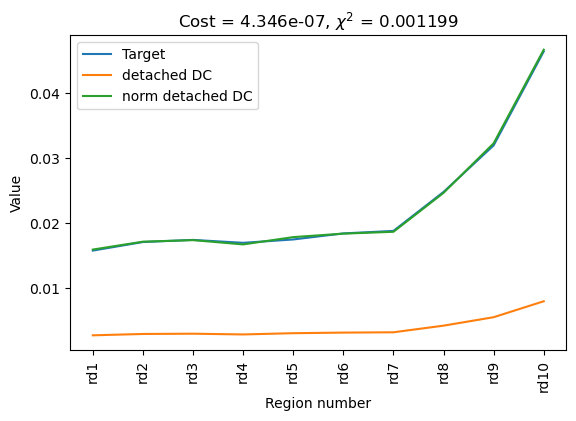

In [16]:
x=np.array(range(model.expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.plot(x,target,label='Target')
#ax.plot(x,resM,label='mobile DC')
ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='norm detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('expEdita_DG_10reg_10dv_3W_dv_intensity_20240924_target.png')
plt.savefig('expEdita_DG_10reg_10dv_3W_dv_intensity_20240924_target.pdf')
plt.savefig('expEdita_DG_10reg_10dv_3W_dv_intensity_20240924_target.svg')

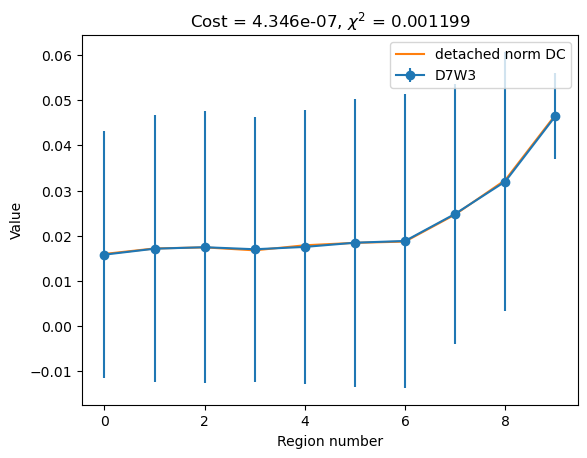

In [17]:
#plt.plot(x,target,label=cname7)
plt.errorbar(x,target,targSD,label=cname7, fmt='-o')
#plt.plot(x,resF,label='detached DC')
plt.plot(x,resF/(1-mProp),label='detached norm DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('expEdita_DG_10reg_10dv_3W_dv_intensity_20240924_target_error.png')
plt.savefig('expEdita_DG_10reg_10dv_3W_dv_intensity_20240924_target_error.pdf')
plt.savefig('expEdita_DG_10reg_10dv_3W_dv_intensity_20240924_target_error.svg')

# 18 month data

In [18]:
expD=pd.read_csv('data/DG_intensity_values_15072024.csv')
#expD=pd.read_csv('data/DG_density_values_15072024.csv')
bgSignal=1e-5
cname0='D0M18'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

cname7='D7M18'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #results to fit to
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point
model.target=target
model.targSD=targSD
model.tnorm=tnorm

## Degradation adjusted

In [19]:
par_dev = par.copy()
dv_val = [-6.065899818591827,-6.043776755867498,-6.052062253128584,-6.063207876305187,-6.0529615522823015,-6.060900289340932,-6.023641831345007,-5.9822075421541285,-5.984436746450736,-6.012401617312046]
dv_18M = np.array(dv_val)
#par_dev[13:] = [
cost = 1.3165035905099785e-06
chi2 = 0.6903653965796307

In [20]:
model.dinit=dinit
utrace = model.calcUtrace(dv_val)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], model.segIdx, model.expD['Abbreviation'], fun=np.sum)

In [21]:
{'F' : par_dev[0],
'Ctau' : par_dev[1],
'mProp' : par_dev[2],
'(1-mProp)' : (1-par_dev[2]),
'demand_rd1' : par_dev[3],
'demand_rd2' : par_dev[4],
'demand_rd3' : par_dev[5],
'demand_rd4' : par_dev[6],
'demand_rd5' : par_dev[7],
'demand_rd6' : par_dev[8],
'demand_rd7' : par_dev[9],
'demand_rd8' : par_dev[10],
'demand_rd9' : par_dev[11],
'demand_rd10' : par_dev[12],
#'dv' : par[13],
'dv_rd1' : dv_val[0],
'dv_rd2' : dv_val[1],
'dv_rd3' : dv_val[2],
'dv_rd4' : dv_val[3],
'dv_rd5' : dv_val[4],
'dv_rd6' : dv_val[5],
'dv_rd7' : dv_val[6],
'dv_rd8' : dv_val[7],
'dv_rd9' : dv_val[8],
'dv_rd10' : dv_val[9],
'norm_factor' : (1-mProp),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - model.target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - model.target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - model.target)/model.targSD) ** 2),
'cost' : cost,
'Chi2' : chi2
}

{'F': 0.0,
 'Ctau': -17.999999996898115,
 'mProp': 0.8295867669028679,
 '(1-mProp)': 0.17041323309713208,
 'demand_rd1': 0.9342243392617688,
 'demand_rd2': 1e-07,
 'demand_rd3': 0.7436969370578205,
 'demand_rd4': 0.18090861212130477,
 'demand_rd5': 0.03669676565420942,
 'demand_rd6': 1.9005438889792946e-07,
 'demand_rd7': 0.9971821327488072,
 'demand_rd8': 0.5857165290933648,
 'demand_rd9': 0.0004747792235872804,
 'demand_rd10': 0.0013503241539911826,
 'dv_rd1': -6.065899818591827,
 'dv_rd2': -6.043776755867498,
 'dv_rd3': -6.052062253128584,
 'dv_rd4': -6.063207876305187,
 'dv_rd5': -6.0529615522823015,
 'dv_rd6': -6.060900289340932,
 'dv_rd7': -6.023641831345007,
 'dv_rd8': -5.9822075421541285,
 'dv_rd9': -5.984436746450736,
 'dv_rd10': -6.012401617312046,
 'norm_factor': 0.17041323309713208,
 'sum_resM': 0.8295867669323744,
 'sum_resF': 0.09713795059514481,
 'sum_tot': 0.9267247175275193,
 'err': 1.3165035905098987e-06,
 'err_norm': 4.066553292151058e-05,
 'chi2': 0.6903653965796023

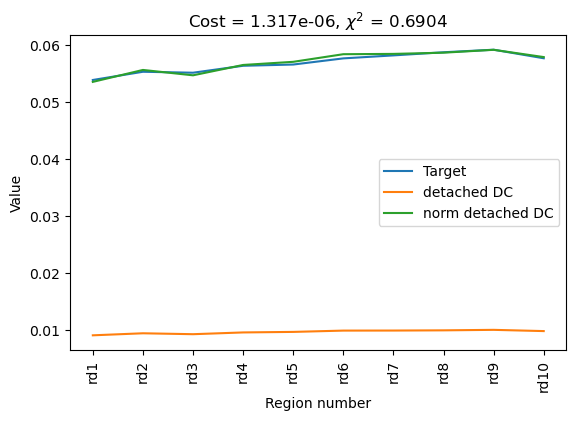

In [22]:
x=np.array(range(model.expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.plot(x,target,label='Target')
#ax.plot(x,resM,label='mobile DC')
ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='norm detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('expEdita_DG_10reg_10dv_18M_dv_intensity_20240924_target.png')
plt.savefig('expEdita_DG_10reg_10dv_18M_dv_intensity_20240924_target.pdf')
plt.savefig('expEdita_DG_10reg_10dv_18M_dv_intensity_20240924_target.svg')

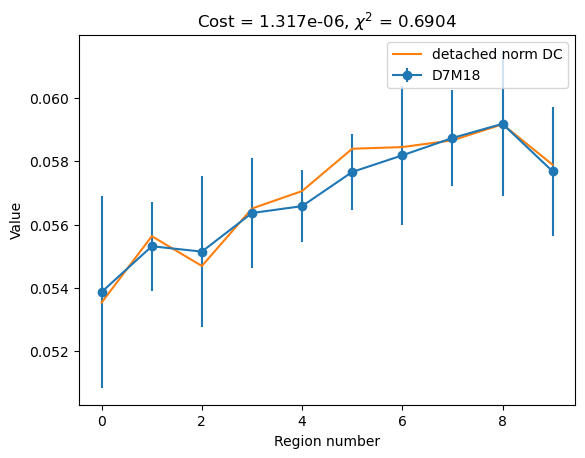

In [23]:
#plt.plot(x,target,label=cname7)
plt.errorbar(x,target,targSD,label=cname7, fmt='-o')
#plt.plot(x,resF,label='detached DC')
plt.plot(x,resF/(1-mProp),label='detached norm DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('expEdita_DG_10reg_10dv_18M_dv_intensity_20240924_target_error.png')
plt.savefig('expEdita_DG_10reg_10dv_18M_dv_intensity_20240924_target_error.pdf')
plt.savefig('expEdita_DG_10reg_10dv_18M_dv_intensity_20240924_target_error.svg')

# Compare dV

In [24]:
{'3W': np.log(2)*7/(10 ** np.array(dv_3W) * day7), 
 '3M': np.log(2)*7/(10 ** np.array(dv_3M) * day7),
 '18M': np.log(2)*7/(10 ** np.array(dv_18M) * day7)}

{'3W': array([3.05109866, 3.03744551, 2.98406348, 2.79053135, 2.83650668,
        2.84894168, 2.75543519, 3.17862186, 3.80240117, 5.35416292]),
 '3M': array([9.27504634, 9.44684154, 9.16744566, 9.07358313, 8.95424369,
        8.5692611 , 8.73487741, 8.00693352, 8.12377167, 9.06553543]),
 '18M': array([9.33708983, 8.87336762, 9.04427943, 9.27939357, 9.06302694,
        9.23021905, 8.47136804, 7.70050595, 7.74013374, 8.25492888])}

In [25]:
{'3W': np.mean(np.log(2)*7/(10 ** np.array(dv_3W) * day7)), 
 '3M': np.mean(np.log(2)*7/(10 ** np.array(dv_3M) * day7)),
 '18M': np.mean(np.log(2)*7/(10 ** np.array(dv_18M) * day7))}

{'3W': 3.2639208510533826, '3M': 8.841753949003614, '18M': 8.699431304384591}

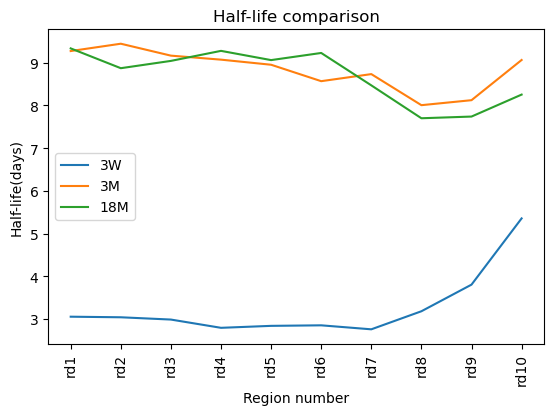

In [26]:
x=np.array(range(model.expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.plot(x,np.log(2)*7/(10 ** np.array(dv_3W) * day7),label='3W')
ax.plot(x,np.log(2)*7/(10 ** np.array(dv_3M) * day7),label='3M')
ax.plot(x,np.log(2)*7/(10 ** np.array(dv_18M) * day7),label='18M')
ax.set_xlabel('Region number')
ax.set_ylabel('Half-life(days)')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
plt.title('Half-life comparison')
# function to show the plot
#plt.show()
plt.savefig('expEdita_DG_intensity_10reg_10dv_halflife.png')
plt.savefig('expEdita_DG_intensity_10reg_10dv_halflife.pdf')
plt.savefig('expEdita_DG_intensity_10reg_10dv_halflife.svg')